# Programming Exercise 7: K-means Clustering and Principal Component Analysis

> In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images.

## 1. K-means Clustering
> In this this exercise, you will implement the K-means algorithm and use it
for image compression.

### 1.1 Implementing K-means

> The K-means algorithm is a method to automatically cluster similar data examples together. The intuition behind K-means is an iterative procedure that starts by guess- ing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

#### 1.1.1 Finding Closest Centroids

For every example $i$ we set $c_{(i)} := j$ that minimizes $||x^{(i)}-\mu_j||^2$ where $c_{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the j'th centroid.

In [1]:
def find_closest_centroid(X, centroids):
    idx = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        idx[i] = np.argmin(np.sqrt(np.sum((X[i,:]-centroids)**2, axis=1)))+1
    return idx

In [2]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mat = scipy.io.loadmat('data/ex7data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [4]:
K = 3
initial_centroids = np.array([[3,3],[6,2],[8,5]])
idx = find_closest_centroid(mat['X'], initial_centroids)
print('Closest centroids for the first 3 examples:', idx[:3].T)
print('(the closest centroids should be 1, 3, 2 respectively)')

Closest centroids for the first 3 examples: [[1. 3. 2.]]
(the closest centroids should be 1, 3, 2 respectively)


#### 1.1.2 Computing Centroid Means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid k we set $\mu_k := \frac{1}{|C_k|}\sum_{i \in C_k}x^{(i)}$

In [5]:
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i,:] = np.mean(X[(idx==i+1).T[0], :], axis=0)
    return centroids

In [6]:
centroids = compute_centroids(mat['X'], idx, K)
print('Centroids computed after initial finding of closest centroids: \n', centroids)
print('\n(the centroids should be\n [ 2.428301 3.157924 ]\n[ 5.813503 2.633656 ]\n[ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids: 
 [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

(the centroids should be
 [ 2.428301 3.157924 ]
[ 5.813503 2.633656 ]
[ 7.119387 3.616684 ]


### 1.2 K-means on example dataset

In [7]:
def plot_kmeans(X, centroids, previous, idx, K, axes):
    for i, ax in enumerate(axes):
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=idx.ravel(), legend=False, palette=['r', 'g', 'b'], ax=ax)
        if i==0:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        else:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        for i in range(centroids.shape[0]):
            ax.plot([centroids[i,0], previous[i,0]], [centroids[i,1], previous[i,1]], '--k');        

In [8]:
def kmeans(X, initial_centroids, max_iters, plot_progress):
    if plot_progress:
        ncols = 5
        nrows = int(max_iters/ncols)
        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,nrows*5))
        ax_tuple = list(np.ndindex(nrows,ncols))
    
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids

    for i in range(max_iters):
        idx = find_closest_centroid(X, centroids)
        
        if plot_progress:
            plot_axes = [axes[axi] for axi in ax_tuple[i:]]
            axes[ax_tuple[i]].set_title('K-Means iteration {0}/{1}'.format(i+1, max_iters))
            plot_kmeans(X, centroids, previous_centroids, idx, K, plot_axes)
            previous_centroids = centroids
            previous_ax = plt.gca()
        else:
            print('K-Means iteration {0}/{1}'.format(i+1, max_iters))
        centroids = compute_centroids(X, idx, K)
    plt.show()
    return centroids, idx

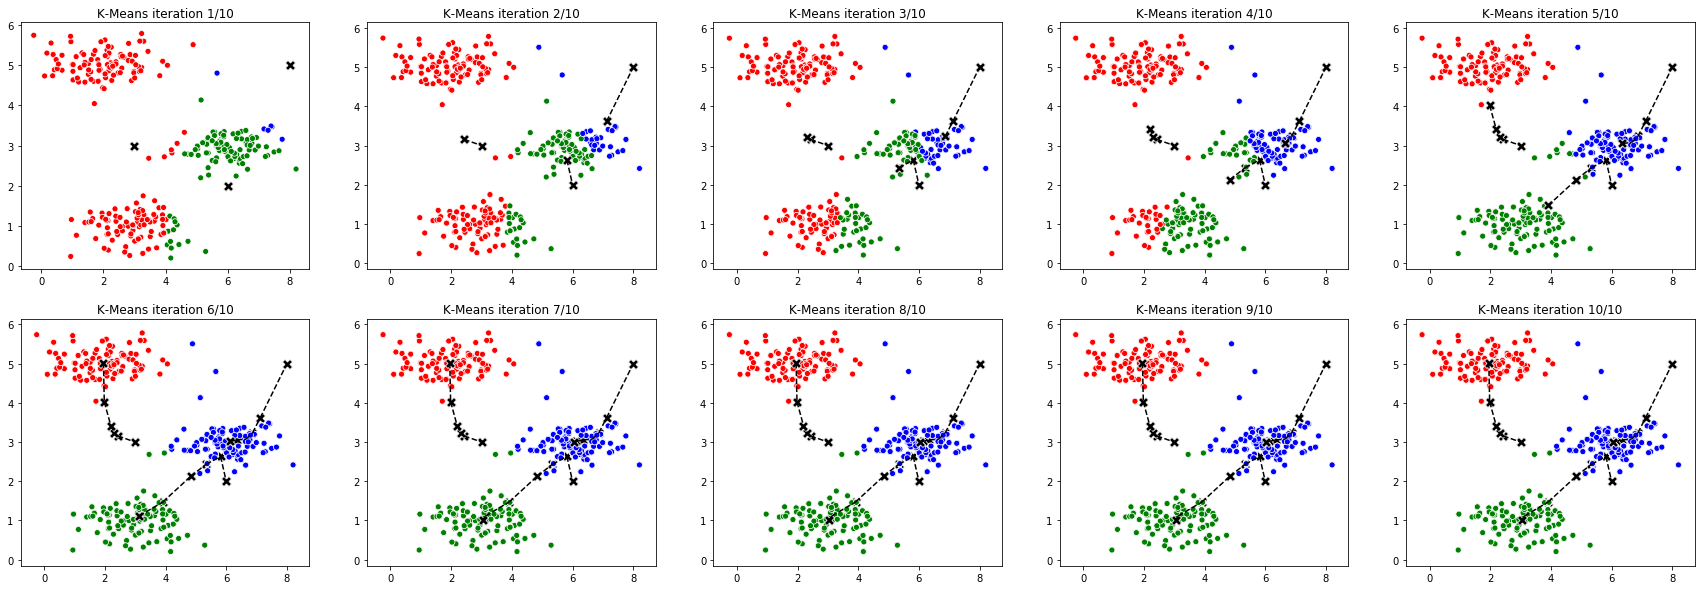

In [9]:
K = 3
max_iters = 10
initial_centroids = np.array([[3,3],[6,2],[8,5]])
centroids, idx = kmeans(mat['X'], initial_centroids, max_iters, True)

### 1.3 Random initialization

In [10]:
def init_random_centroids(X, K):
    centroids = X[(np.random.choice(X.shape[0], K)), :]
    return centroids

### 1.4 Image Compression with K-means

> In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### 1.4.1 K-means on pixels

##### Load image

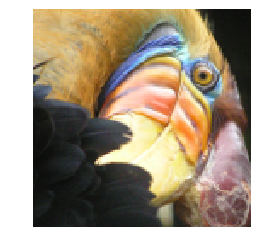

In [11]:
import cv2
img = cv2.imread('data/bird_small.png')
plt.axis('off');
plt.imshow(img[:,:,::-1]);

In [12]:
A = img[:,:,::-1]
A = np.divide(img, 255) #get all values in range 0-1

In [13]:
A.shape

(128, 128, 3)

In [14]:
A = A.reshape((A.shape[0]*A.shape[1], 3))

In [15]:
A.shape

(16384, 3)

##### Run K-Means

In [16]:
K = 16
max_iters = 10
initial_centroids = init_random_centroids(A, K)
centroids, idx = kmeans(A, initial_centroids, max_iters, False)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


##### Apply K-Means to compress an image

In [17]:
idx = find_closest_centroid(A, centroids)
idx = idx.astype(int)

In [18]:
idx.shape

(16384, 1)

In [19]:
X_recovered = np.zeros((idx.shape[0], 3))
for i in range(idx.shape[0]):
    X_recovered[i,:] = centroids[idx[i]-1,:]

In [20]:
X_recovered = X_recovered.reshape((img.shape[0], img.shape[1], 3))

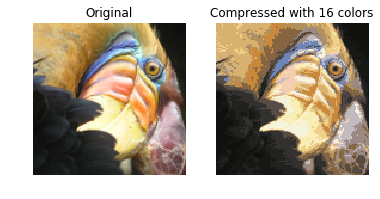

In [21]:
plt.subplot(1,2,1)
plt.axis('off');
plt.title('Original')
plt.imshow(img[:,:,::-1]);

plt.subplot(1,2,2)
plt.axis('off');
plt.title('Compressed with 16 colors')
plt.imshow(X_recovered[:,:,::-1]);

In [22]:
K_vals = [2, 8, 16, 24, 36]
max_iters = 10

imgs_compressed = []        
for ik,K in enumerate(K_vals):
    print('\nRunning K-Means with K={}'.format(K))
    #run kmeans
    initial_centroids = init_random_centroids(A, K)
    centroids, idx = kmeans(A, initial_centroids, max_iters, False)
    #image compression
    idx = find_closest_centroid(A, centroids)
    idx = idx.astype(int)
    #recover image
    X_recovered = np.zeros((idx.shape[0], 3))
    for i in range(idx.shape[0]):
        X_recovered[i,:] = centroids[idx[i]-1,:]
    X_recovered = X_recovered.reshape((img.shape[0], img.shape[1], 3))
    imgs_compressed.append(X_recovered)


Running K-Means with K=2
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=8
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=16
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10

Running K-Means with K=24
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration

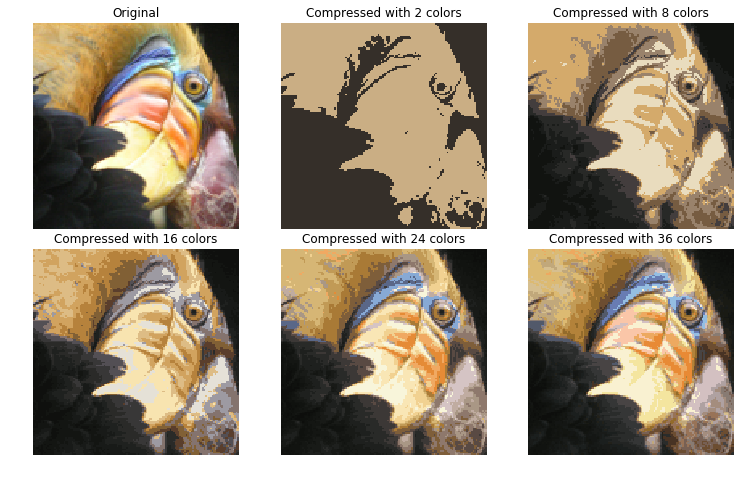

In [23]:
fig = plt.figure(figsize=(10,6))
rows = 2
cols = 3
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img[:,:,::-1])
ax1.set_axis_off()
ax1.set_title('Original')
for i in range(len(imgs_compressed)):
    ax1 = fig.add_subplot(rows, cols, i+2)
    ax1.imshow(imgs_compressed[i][:,:,::-1])
    ax1.set_axis_off()
    ax1.set_title('Compressed with {} colors'.format(K_vals[i]))
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

## 2. Principal Component Analysis

> In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

### 2.1 Example Dataset

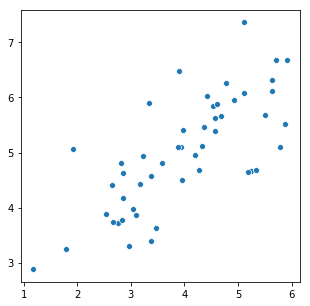

In [24]:
mat = scipy.io.loadmat('data/ex7data1.mat')
plt.figure(figsize=(5,5))
sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1])        

### 2.2 Implementing PCA

PCA consists of two computational steps: First, you compute the covariance matrix of the data. Then, you use SVD function to compute the eigenvectors $U1, U2, ... , Un$. These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In [25]:
def feature_normalize(X):
    mean = np.mean(X, axis=0)
    X_norm = np.subtract(X,mean)
    
    std = np.std(X_norm, axis=0, ddof=1)
    X_norm = X_norm/std
    return X_norm, mean, std

Covariance matrix: $\Sigma = \frac{1}{m}X^TX$
<br>
SVD computes the principal components.

In [26]:
def pca(X):
    m = X.shape[0]
    covariance_matrix = (1/m) * (X.T.dot(X))
    U, S, _ = np.linalg.svd(covariance_matrix)
    return U, S

In [27]:
X_norm, mu, sigma = feature_normalize(mat['X'])

In [28]:
U, S = pca(X_norm)

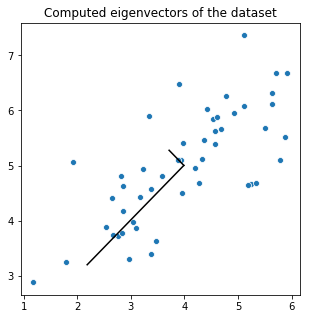

In [29]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1])

p1 = mu
p2 = mu + 1.5 * S[0] * U[:,0].T
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k');  

p1 = mu
p2 = mu + 1.5 * S[1] * U[:,1].T
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k');  
plt.title('Computed eigenvectors of the dataset');

In [30]:
print('Top eigenvector:')
print(' U(:,1) = ', U[0,0], U[1,0])
print('(you should expect to see -0.707107 -0.707107)')

Top eigenvector:
 U(:,1) =  -0.7071067811865472 -0.7071067811865475
(you should expect to see -0.707107 -0.707107)


### 2.3 Dimensionality Reduction with PCA

#### 2.3.1 Projecting the data onto the principal components

In [31]:
def project_data(X, U, K):
    Z = np.zeros((X.shape[0], K))
    for i in range(X.shape[0]):
        x = X[i,:].T
        for j in range(K):
            Z[i,j] = x.T.dot(U[:,j])
    return Z

In [32]:
K=1
Z = project_data(X_norm, U, K)
print('Projection of the first example:', Z[0])
print('(this value should be about 1.481274)')

Projection of the first example: [1.48127391]
(this value should be about 1.481274)


#### 2.3.2 Reconstructing an approximation of the data

In [33]:
def recover_data(Z, U, K):
    X_rec = np.zeros((Z.shape[0], U.shape[0]))
    for i in range(Z.shape[0]):
        z = Z[i,:].T
        for j in range(U.shape[0]):
            X_rec[i,j] = z.T.dot(U[j,:K])
    return X_rec

In [34]:
X_rec = recover_data(Z, U, K)
print('Approximation of the first example:', X_rec[0, 0], X_rec[0, 1])
print('(this value should be about  -1.047419 -1.047419)')

Approximation of the first example: -1.0474188259204957 -1.047418825920496
(this value should be about  -1.047419 -1.047419)


#### 2.3.3 Visualizing the projections

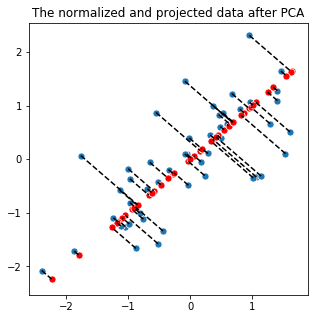

In [35]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x=X_norm[:,0], y=X_norm[:,1], s=50)
ax = sns.scatterplot(x=X_rec[:,0], y=X_rec[:,1], color='r', s=50)
for i in range(X_norm.shape[0]):
    p1 = X_norm[i,:]
    p2 = X_rec[i,:]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], '--k')
plt.title('The normalized and projected data after PCA');

### 2.4 Face Image Dataset

In [36]:
mat = scipy.io.loadmat('data/ex7faces.mat')

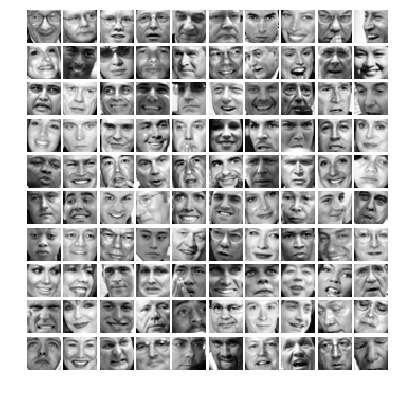

In [37]:
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(mat['X'][count].reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

#### 2.4.1 PCA on Faces

In [38]:
X_norm, mu, sigma = feature_normalize(mat['X'])

In [39]:
U, S = pca(X_norm)

In [40]:
U.shape

(1024, 1024)

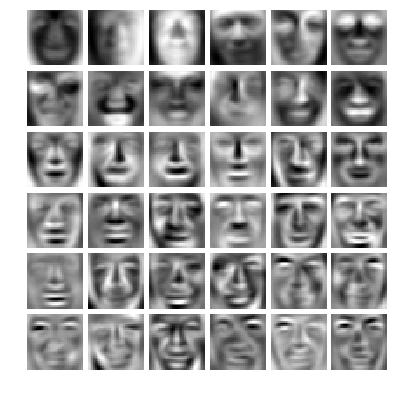

In [41]:
rows = 6
cols = 6
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(rows):
    for j in range(cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(U[:, count].T.reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

#### 2.4.2 Dimensionality Reduction

In [42]:
K=100
Z = project_data(X_norm, U, K)

In [43]:
print('The projected data Z has a size of: ', Z.shape)

The projected data Z has a size of:  (5000, 100)


Visualizing the reduced dimension faces

In [44]:
X_rec  = recover_data(Z, U, K)

Original:

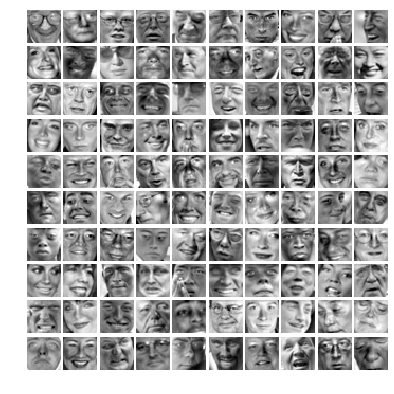

In [45]:
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(rows):
    for j in range(cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(X_norm[count].reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

Reconstructed

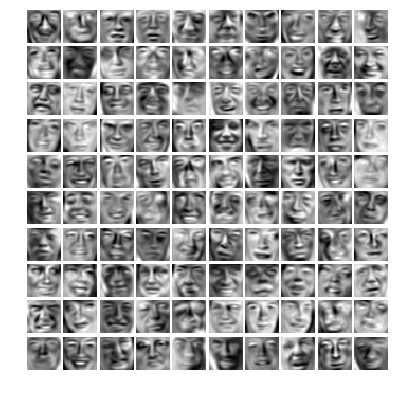

In [46]:
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
count = 0
for i in range(rows):
    for j in range(cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(X_rec[count].reshape(32,32).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

### 2.5 PCA for visualization

In [51]:
img = cv2.imread('data/bird_small.png')

A = img[:,:,::-1]
A = np.divide(img, 255) #get all values in range 0-1

A = A.reshape((A.shape[0]*A.shape[1], 3), order='F')

K = 16
max_iters = 10
initial_centroids = init_random_centroids(A, K)
centroids, idx = kmeans(A, initial_centroids, max_iters, False)

K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


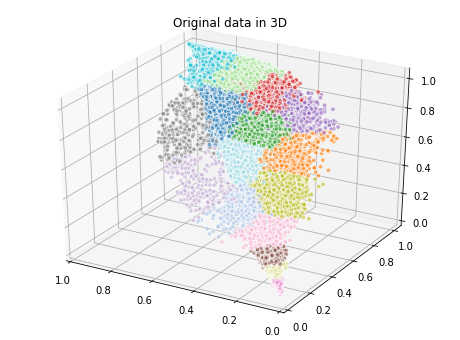

In [61]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(A[:,0], A[:,1], A[:,2], alpha=0.6, edgecolors='w', c=idx.ravel(), cmap=plt.get_cmap("tab20"))
ax.set_xlim(1, 0)

plt.title('Original data in 3D');
plt.show()

In [57]:
X_norm, mu, sigma = feature_normalize(A)
U, S = pca(X_norm)
Z = project_data(X_norm, U, 2)

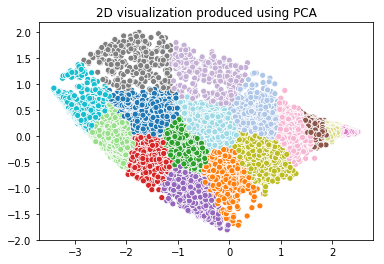

In [58]:
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=idx.ravel(), legend=False, palette=plt.get_cmap("tab20"))
plt.title('2D visualization produced using PCA');